# Convolutional Neural Network for trash classification

In [1]:
import numpy as np
import tensorflow as tf

# TensorFlow and keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential

import matplotlib.pyplot as plt

2024-07-12 11:29:01.276848: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 11:29:01.302781: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 11:29:01.302836: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-12 11:29:01.319104: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-12 11:29:02.742514: W tensorflow/compiler/tf

Read the data and split it into training and validation sets

In [2]:
data_dir = '/home/dmitri/Documents/CMKL/Warp2024/CnnTrash/dataset-resized'

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode='int',
  subset="training",
  seed = 1227,
  image_size=(224, 224),
  batch_size=32)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [4]:
valid_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode='int',
  subset="validation",
  seed = 1227,
  image_size=(224, 224),
  batch_size=32)

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [5]:
# Our classes

class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


2024-07-12 11:29:05.544070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


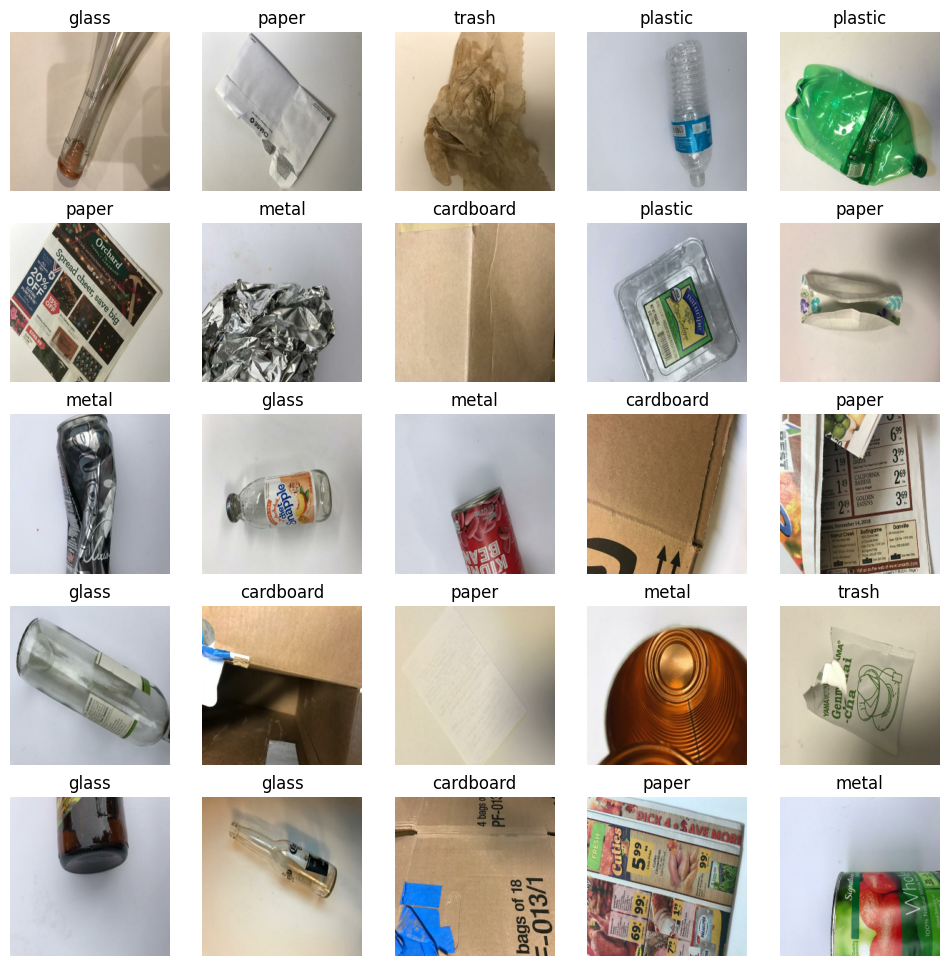

In [6]:
# Example of images

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Create our neural network

We can modify this part to more intricate models

In [7]:
model = Sequential(
    [
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(6)
    ]
)

/home/dmitri/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,768,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,825,670 (10.78 MB)

 Trainable params: 2,825,670 (10.78 MB)

 Non-trainable params: 0 (0.00 B)

## Save checkpoints during training

The ``tf.keras.callbacks.ModelCheckpoint`` callback allows you to continually save the model both during and at the end of training.

In [17]:
checkpoint_path = '/home/dmitri/Documents/CMKL/Warp2024/CnnTrash/Model/checkpoint.model.keras'

## Train and save our neural network

In [18]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    save_weights_only=False,
    verbose=1)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=(valid_ds),
    callbacks=[cp_callback]
)

Epoch 1/10


2024-07-12 11:37:23.135959: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201867264 exceeds 10% of free system memory.
2024-07-12 11:37:23.434435: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 97329152 exceeds 10% of free system memory.
2024-07-12 11:37:23.868318: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 97329152 exceeds 10% of free system memory.
2024-07-12 11:37:24.246871: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 100933632 exceeds 10% of free system memory.
2024-07-12 11:37:24.246958: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201867264 exceeds 10% of free system memory.


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2103 - loss: 75.6382
Epoch 1: saving model to /home/dmitri/Documents/CMKL/Warp2024/CnnTrash/Model/checkpoint.model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.2108 - loss: 74.8429 - val_accuracy: 0.2614 - val_loss: 1.7169
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3570 - loss: 1.5684
Epoch 2: saving model to /home/dmitri/Documents/CMKL/Warp2024/CnnTrash/Model/checkpoint.model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.3573 - loss: 1.5681 - val_accuracy: 0.3050 - val_loss: 1.7691
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4713 - loss: 1.3411
Epoch 3: saving model to /home/dmitri/Documents/CMKL/Warp2024/CnnTrash/Model/checkpoint.model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.4714 - loss: 1.3409 - val_accuracy: 0.2990 - val_loss: 1.9551
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5891 - loss: 1.0614
Epoch 4: saving model to /home

## Evaluate our model

Text(0.5, 0, 'epoch')

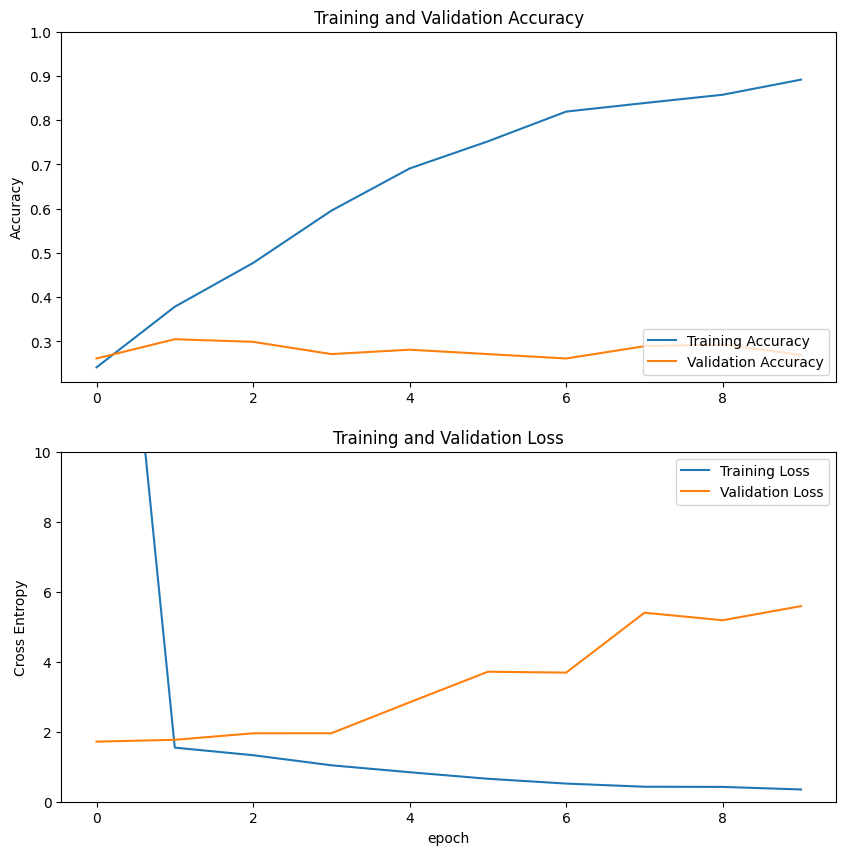

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

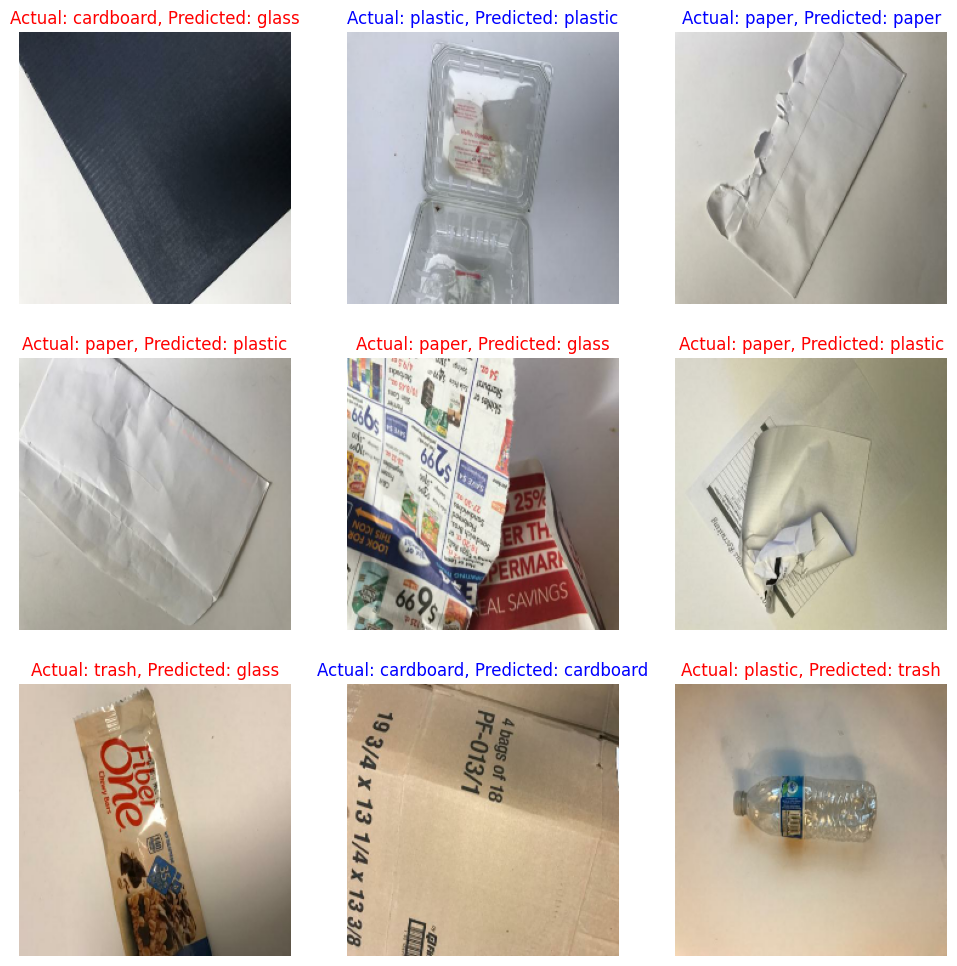

In [20]:
image_batch, label_batch = valid_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    actual_label = class_names[label_batch[i]]
    predicted_label = class_names[np.argmax(predictions[i])]

    if actual_label == predicted_label:
        plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}", c='b')
    else:
        plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}", c='r')

    plt.axis("off")

# Adjust the space between the plots
plt.subplots_adjust(wspace=0.2, hspace=0.2)